**Model 1 (Bert + Fine Tuning + Layer Added)**
1. Pre-trained Bert Model with an additional custom layer at the top - includes a linear layer that projects the BERT model's hidden size to 1024 dimensions, a ReLU activation function, a dropout layer for regularization, and another linear layer that projects down to the number of classes for the final output

2. Binary Cross-Entropy (BCE) and Focal Loss  as loss functions
    
*   Binary Cross-Entropy (BCE) - As each sample can belong to more than one class simultaneously, each class label is treated as an independent binary classification. The BCE loss function is defined as:
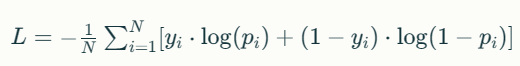

  where N is the number of samples, y_i is the actual label for the i-th sample, and p_i is the predicted probability of the i-th sample for being in the class.


*   Focal Loss as loss function -  Used to address the problem of class imbalance, as it is used particularly in scenarios where there is a significant imbalance between the classes, such as one class being much more frequent than the other.
     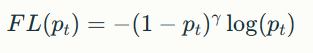
  
  where p_t is the model's estimated probability for the class with the true label, and γ is a tunable focusing parameter, typically greater than 0. When γ is 0, focal loss is equivalent to cross-entropy loss.


**Results for BCE Loss**

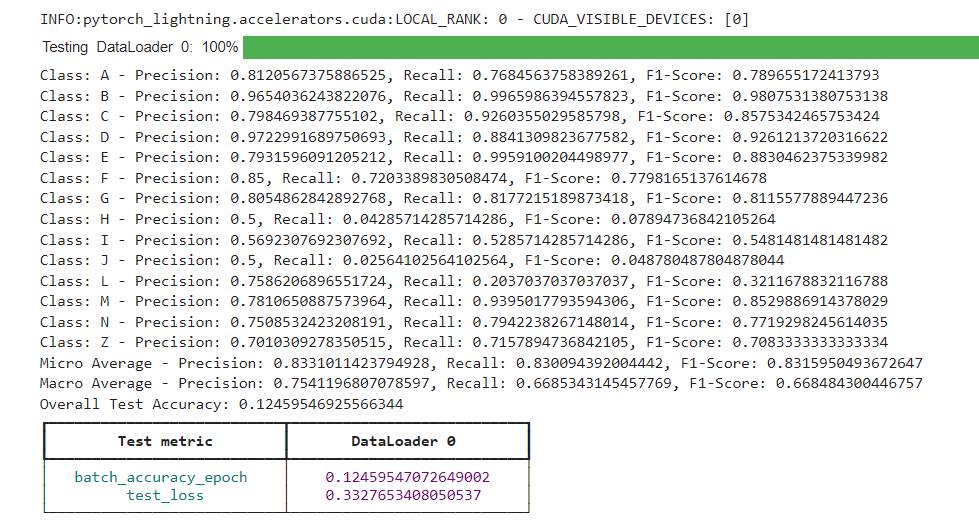

**Results for Focal Loss**

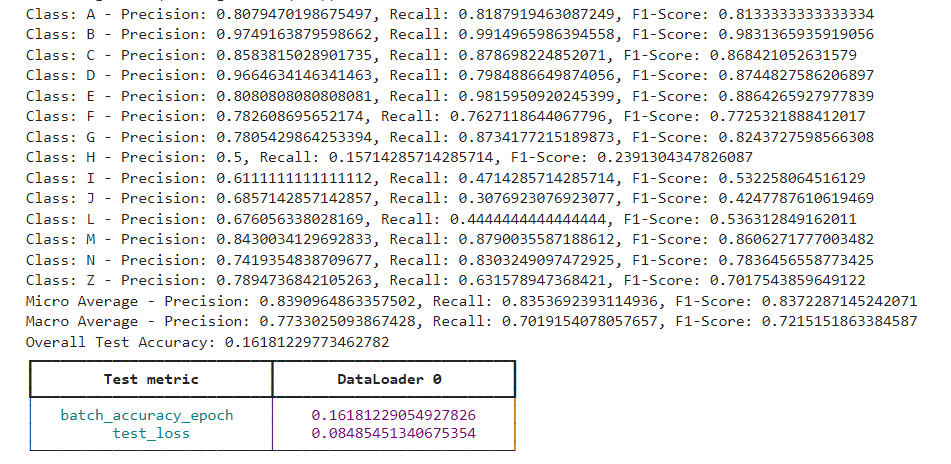

**Observations**:
* We can observe that for Focal Loss model, the acccuracy is high and loss is less at the same time precision score has improved slightly.
* This model took less time as compared to just fine-tuned model(without adding layer) for getting the same accuracy and other metrics

In [ ]:
!pip install pytorch-lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 801.9/801.9 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 49.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-man

In [ ]:
pip install -U typing_extensions

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report, precision_recall_fscore_support

In [ ]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer

# dataset_name = r"C:\Users\Dell\Desktop\Sem_8\Ell881_Modern_NLP\Assignment 3\Multi-Label Text Classification Dataset.csv"
dataset_name = r"/content/Multi-Label Text Classification Dataset.csv"

df = pd.read_csv(dataset_name, engine='python', on_bad_lines='skip')
# Fill NaN values with empty strings in both 'Title' and 'abstractText' columns
df['Title'] = df['Title'].fillna('')
df['abstractText'] = df['abstractText'].fillna('')

# Create a smaller DataFrame with the first 1000 rows
# df = df.sample(n=1000, random_state=1)

# Define the label mappings
label_mappings = {
    "A": "Anatomy",
    "B": "Organisms",
    "C": "Diseases",
    "D": "Chemicals and Drugs",
    "E": "Analytical, Diagnostic and Therapeutic Techniques, and Equipment",
    "F": "Psychiatry and Psychology",
    "G": "Phenomena and Processes",
    "H": "Disciplines and Occupations",
    "I": "Anthropology, Education, Sociology, and Social Phenomena",
    "J": "Technology, Industry, and Agriculture",
    "L": "Information Science",
    "M": "Named Groups",
    "N": "Health Care",
    "Z": "Geographicals"
}

# Extract the labels for each row and convert them into a list of lists
labels = []
for index, row in df.iterrows():
    row_labels = [label for label, present in row[label_mappings.keys()].items() if present == 1]
    labels.append(row_labels)

# Encode labels as one-hot vectors
mlb = MultiLabelBinarizer()
df['one_hot_labels'] = list(mlb.fit_transform(labels))

In [ ]:
print(df.columns)

Index(['Title', 'abstractText', 'meshMajor', 'pmid', 'meshid', 'meshroot', 'A',
       'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'L', 'M', 'N', 'Z',
       'one_hot_labels'],
      dtype='object')


In [ ]:
# Split the dataset into train, validation, and test sets
x_train, x_test, y_train, y_test = train_test_split(df[['Title', 'abstractText']], df['one_hot_labels'], test_size=0.1, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)


In [ ]:
# Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# Dataset class
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        # Convert both title and abstractText to strings, handling any missing values
        title = str(self.texts.iloc[idx]['Title'])
        abstract = str(self.texts.iloc[idx]['abstractText'])

        # Concatenate title and abstract, separating them with a space
        text = title + ' ' + abstract

        # text = self.texts.iloc[idx]['Title'] + ' ' + self.texts.iloc[idx]['abstractText']
        labels = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.FloatTensor(labels)
        }

In [ ]:
# DataModule class
class DataModule(pl.LightningDataModule):
    def __init__(self, train_dataset, val_dataset, test_dataset, batch_size=16):
        super().__init__()
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.test_dataset = test_dataset
        self.batch_size = batch_size

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size)

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support

In [ ]:
import torch.nn.functional as F

class MultiLabelClassifier(pl.LightningModule):
    def __init__(self, n_classes, loss_type='BCEWithLogitsLoss', steps_per_epoch=None, n_epochs=3, lr=2e-5):
        super().__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        # Adding an additional linear layer and a dropout layer
        self.classifier = nn.Sequential(
            nn.Linear(self.bert.config.hidden_size, 1024),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(1024, n_classes)
        )

        # Choose the loss function based on the input parameter
        if loss_type == 'BCEWithLogitsLoss':
            self.criterion = nn.BCEWithLogitsLoss()
        elif loss_type == 'FocalLoss':
            self.criterion = FocalLoss(alpha=1, gamma=2, logits=True, reduce=True)
        else:
            raise ValueError("Invalid loss type provided: choose 'BCEWithLogitsLoss' or 'FocalLoss'")

        self.steps_per_epoch = steps_per_epoch
        self.n_epochs = n_epochs
        self.lr = lr

    def forward(self, input_ids, attention_mask):
        output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        return self.classifier(output.pooler_output)
    def training_step(self, batch, batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']
        outputs = self(input_ids, attention_mask)
        loss = self.criterion(outputs, labels)
        self.log('train_loss', loss, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']
        outputs = self(input_ids, attention_mask)
        val_loss = self.criterion(outputs, labels)
        self.log('val_loss', val_loss, prog_bar=True, logger=True)
        return val_loss

    def test_step(self, batch, batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']
        outputs = self(input_ids, attention_mask)
        loss = self.criterion(outputs, labels)
        self.log('test_loss', loss, prog_bar=True, logger=True)

        # Apply sigmoid to get probabilities and round to get predictions
        preds = torch.sigmoid(outputs).round().int()

        # Save the labels and predictions as instance attributes
        if batch_idx == 0:
            self.predictions = preds
            self.labels = labels.int()
        else:
            self.predictions = torch.cat((self.predictions, preds), dim=0)
            self.labels = torch.cat((self.labels, labels.int()), dim=0)

        # Calculate and log batch accuracy
        batch_accuracy = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())
        self.log('batch_accuracy', batch_accuracy, on_step=True, on_epoch=True, prog_bar=True, logger=True)

        return {'test_loss': loss, 'batch_accuracy': batch_accuracy}

    def on_test_epoch_end(self):
        all_preds = self.predictions.cpu()  # Move to CPU
        all_labels = self.labels.cpu()  # Move to CPU

        all_preds_np = all_preds.numpy()
        all_labels_np = all_labels.numpy()

        # Calculate metrics for each class
        for i, class_name in enumerate(mlb.classes_):
            precision, recall, f1, _ = precision_recall_fscore_support(all_labels_np[:, i], all_preds_np[:, i], average='binary')
            print(f"Class: {class_name} - Precision: {precision}, Recall: {recall}, F1-Score: {f1}")

        # Calculate micro and macro averages for precision, recall, and F1-score
        precision_micro, recall_micro, f1_micro, _ = precision_recall_fscore_support(all_labels_np, all_preds_np, average='micro')
        precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(all_labels_np, all_preds_np, average='macro')

        print(f"Micro Average - Precision: {precision_micro}, Recall: {recall_micro}, F1-Score: {f1_micro}")
        print(f"Macro Average - Precision: {precision_macro}, Recall: {recall_macro}, F1-Score: {f1_macro}")

        # Calculate overall accuracy
        overall_accuracy = accuracy_score(all_labels_np, all_preds_np)
        print(f"Overall Test Accuracy: {overall_accuracy}")

    def configure_optimizers(self):
        return torch.optim.Adam(params=self.parameters(), lr=self.lr)

In [ ]:
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, logits=True, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduce=False)
        else:
            BCE_loss = F.binary_cross_entropy(inputs, targets, reduce=False)

        pt = torch.exp(-BCE_loss)  # prevents nans when probability 0
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

In [ ]:
import pytorch_lightning as pl
print(pl.__version__)

2.2.2


In [ ]:
pip install --upgrade pytorch-lightning

In [ ]:
# Prepare datasets
train_dataset = TextDataset(x_train, np.array(y_train.tolist()), tokenizer)
val_dataset = TextDataset(x_val, np.array(y_val.tolist()), tokenizer)
test_dataset = TextDataset(x_test, np.array(y_test.tolist()), tokenizer)

data_module = DataModule(train_dataset, val_dataset, test_dataset, batch_size=16)

# Instantiate the model with BCEWithLogitsLoss
model1 = MultiLabelClassifier(n_classes=len(mlb.classes_), loss_type='BCEWithLogitsLoss', steps_per_epoch=len(train_dataset)//16, n_epochs=3, lr=2e-5)

trainer = pl.Trainer(max_epochs=3, accelerator='gpu', devices=1 if torch.cuda.is_available() else None)

# Train the model
trainer.fit(model1, data_module)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type              | Params
-------------------------------------------------
0 | bert       | BertModel         | 109 M 
1 | classifier | Sequential        | 801 K 
2 | criterion  | BCEWithLogitsLoss | 0     
-------------------------------------------------
110 M     Trainable params
0         Non-trainable params
110 M     Total params
441.136   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


Model saved for Binary Cross-Entropy (BCE) Loss

In [ ]:
# Evaluate the model
trainer.test(model1, datamodule=data_module)

# Save the model
torch.save(model1.state_dict(), 'multi_label_text_classification_model1.pth')

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

Class: A - Precision: 0.8120567375886525, Recall: 0.7684563758389261, F1-Score: 0.789655172413793
Class: B - Precision: 0.9654036243822076, Recall: 0.9965986394557823, F1-Score: 0.9807531380753138
Class: C - Precision: 0.798469387755102, Recall: 0.9260355029585798, F1-Score: 0.8575342465753424
Class: D - Precision: 0.9722991689750693, Recall: 0.8841309823677582, F1-Score: 0.9261213720316622
Class: E - Precision: 0.7931596091205212, Recall: 0.9959100204498977, F1-Score: 0.8830462375339982
Class: F - Precision: 0.85, Recall: 0.7203389830508474, F1-Score: 0.7798165137614678
Class: G - Precision: 0.8054862842892768, Recall: 0.8177215189873418, F1-Score: 0.8115577889447236
Class: H - Precision: 0.5, Recall: 0.04285714285714286, F1-Score: 0.07894736842105264
Class: I - Precision: 0.5692307692307692, Recall: 0.5285714285714286, F1-Score: 0.5481481481481482
Class: J - Precision: 0.5, Recall: 0.02564102564102564, F1-Score: 0.048780487804878044
Class: L - Precision: 0.7586206896551724, Recall: 0

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│   batch_accuracy_epoch    │    0.12459547072649002    │
│         test_loss         │    0.3327653408050537     │
└───────────────────────────┴───────────────────────────┘

Model saved for Binary Focal Loss

In [ ]:
# Instantiate the model with FocalLoss
model2 = MultiLabelClassifier(n_classes=len(mlb.classes_), loss_type='FocalLoss', steps_per_epoch=len(train_dataset)//16, n_epochs=3, lr=2e-5)
trainer = pl.Trainer(max_epochs=3, accelerator='gpu', devices=1 if torch.cuda.is_available() else None)
# trainer = pl.Trainer(max_epochs=3)

# Train the model
trainer.fit(model2, data_module)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type       | Params
------------------------------------------
0 | bert       | BertModel  | 109 M 
1 | classifier | Sequential | 801 K 
2 | criterion  | FocalLoss  | 0     
------------------------------------------
110 M     Trainable params
0         Non-trainable params
110 M     Total params
441.136   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


In [ ]:
# Evaluate the model
trainer.test(model2, datamodule=data_module)

# Save the model
torch.save(model2.state_dict(), 'multi_label_text_classification_model2.pth')

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warnin

Class: A - Precision: 0.8079470198675497, Recall: 0.8187919463087249, F1-Score: 0.8133333333333334
Class: B - Precision: 0.9749163879598662, Recall: 0.9914965986394558, F1-Score: 0.9831365935919056
Class: C - Precision: 0.8583815028901735, Recall: 0.878698224852071, F1-Score: 0.868421052631579
Class: D - Precision: 0.9664634146341463, Recall: 0.7984886649874056, F1-Score: 0.8744827586206897
Class: E - Precision: 0.8080808080808081, Recall: 0.9815950920245399, F1-Score: 0.8864265927977839
Class: F - Precision: 0.782608695652174, Recall: 0.7627118644067796, F1-Score: 0.7725321888412017
Class: G - Precision: 0.7805429864253394, Recall: 0.8734177215189873, F1-Score: 0.8243727598566308
Class: H - Precision: 0.5, Recall: 0.15714285714285714, F1-Score: 0.2391304347826087
Class: I - Precision: 0.6111111111111112, Recall: 0.4714285714285714, F1-Score: 0.532258064516129
Class: J - Precision: 0.6857142857142857, Recall: 0.3076923076923077, F1-Score: 0.4247787610619469
Class: L - Precision: 0.6760

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│   batch_accuracy_epoch    │    0.16181229054927826    │
│         test_loss         │    0.08485451340675354    │
└───────────────────────────┴───────────────────────────┘